In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_vars(fname, dirname, dep_ind, time_ind):
    
    if fname == '1_MCKNZ_1h_20170101_201701*':
        maskname = '1_mesh_mask.nc'
    elif fname == 'MCKNZ_1h_20170101_201701*':
        maskname = 'mesh_mask.nc'
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][:]
        vosaline0 = dsT.variables['vosaline'][time_ind, dep_ind, y, x]
        
    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        tmask = dsM.variables['tmask'][0, dep_ind, y, x]
        e3t = dsM.variables['e3t_0'][0, dep_ind, y, x]
        
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vosaline, deptht, tmask, e3t

In [148]:
def get_salt(fname, dirname, time_ind, dep_ind, y, x):
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    with scDataset(filesT) as dsT:
        vosaline = dsT.variables['vosaline'][time_ind, dep_ind, y, x]
        return vosaline

# Summary
Finding the hour when salinities start to go over the max salinity in the initial profile. This is specifically for dep_ind=8 (74 m).

|child           |time [hrs]| salinity|time [hrs]| salinity|
|----------------|--|-----------------|--|-----------------|
|ideal_double_flt|45|35.08|479|36.6084|
|ideal_double (ts)|44|35.0735|-|-|
|**ideal_base_flt**   |86|35.0699|479|35.6176|
|**ideal_base (ts)**  |85|35.0665|-|-|
|**ideal_base_nambfr**|124|35.0636|-|-|
|**ideal_base_e3zps** |-|-|-|-|
|ideal_half      |-|-|-|-|
|real_base       |-|-|-|-|
|real_half       |-|-|-|-|



|parent           |time [hrs]| salinity|time [hrs]| salinity|
|----------------|--|-----------------|--|-----------------|
|ideal_double_flt|43|35.0968|479|36.1203|
|ideal_double (ts)|42|35.0874|-|-|
|**ideal_base_flt**   |293|35.0642|479|35.4966|
|**ideal_base (ts)**  |283|35.0641|-|-|
|**ideal_base_nambfr**|171|35.0631|-|-|
|**ideal_base_e3zps** |-|-|-|-|
|ideal_half      |-|-|-|-|
|real_base       |-|-|-|-|
|real_half       |-|-|-|-|

In [6]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][0, :, 0, 0]
for z in range(len(vosaline_ref)):
    print(str(z) + '-- ' + str(vosaline_ref[z]))
print('MAXIMUM-- ' + str(vosaline_ref.max()))

0-- 22.1943
1-- 27.4241
2-- 28.7108
3-- 29.3442
4-- 29.9331
5-- 30.2523
6-- 30.7269
7-- 31.2098
8-- 31.6015
9-- 31.9925
10-- 32.2865
11-- 32.5529
12-- 32.8522
13-- 33.2351
14-- 33.4181
15-- 33.5879
16-- 33.7455
17-- 33.8842
18-- 34.0275
19-- 34.1689
20-- 34.256
21-- 34.3465
22-- 34.4552
23-- 34.5092
24-- 34.5697
25-- 34.6244
26-- 34.6743
27-- 34.7154
28-- 34.7544
29-- 34.792
30-- 34.8289
31-- 34.8412
32-- 34.862
33-- 34.8812
34-- 34.8961
35-- 34.9088
36-- 34.9198
37-- 34.9309
38-- 34.9304
39-- 34.9413
40-- 34.9496
41-- 34.9564
42-- 34.965
43-- 34.966
44-- 34.9659
45-- 34.9709
46-- 34.9758
47-- 34.9788
48-- 34.9778
49-- 34.9787
50-- 34.9816
51-- 34.9855
52-- 34.9887
53-- 34.9905
54-- 34.9936
55-- 34.9955
56-- 34.9965
57-- 34.9964
58-- 34.9974
59-- 34.9995
60-- 35.0004
61-- 35.0033
62-- 35.0083
63-- 35.0133
64-- 35.0163
65-- 35.0193
66-- 35.0233
67-- 35.0263
68-- 35.0294
69-- 35.0323
70-- 35.0353
71-- 35.0384
72-- 35.0414
73-- 35.0445
74-- 35.0476
75-- 35.0506
76-- 35.0536
77-- 35.0567
7

In [64]:
def plot_salt(fname, dirname, case, time_ind, vosaline_ref, flag):
    fig, axes = plt.subplots(3, 4, figsize=(20, 14), sharex=True, sharey=True)

    dep_inds = np.arange(5, 17)

    for ax, dep_ind in zip(axes.flatten(), dep_inds):

        vosaline, deptht, tmask, e3t = get_vars(fname, dirname+case, dep_ind, time_ind)
        
        if flag == 'anomaly':
            vmin, vmax = -7, 7
            plot_array = vosaline - vosaline_ref[dep_ind]
            cmap = cmo.cm.delta
        else:    
            vmin, vmax = 34.5, 35.063
            plot_array = vosaline
            cmap = cm.Spectral_r

        salmax_y = np.where(plot_array == plot_array.max())[-2][0]
        salmax_x = np.where(plot_array == plot_array.max())[-1][0]
        salmax_e3t = e3t[salmax_y, salmax_x]
        salmax_tmask = tmask[salmax_y, salmax_x]
        salmax_salt = plot_array[salmax_y, salmax_x]
        e3t_tmask = salmax_e3t * salmax_tmask

        
        cmap.set_bad('silver')
        xs = np.arange(vosaline.shape[-1])
        ys = np.arange(vosaline.shape[-2])
        
        p = ax.pcolormesh(xs, ys, plot_array, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(salmax_x, salmax_y, s=200, facecolors='none', edgecolors='w', lw=2)
        ax.annotate('salt = '+str(np.round(salmax_salt, 3)), xy=(130, 20), fontsize=16)
        ax.annotate('thick = '+str(np.round(e3t_tmask, 3)), xy=(130, 10), fontsize=16)
        ax.set_aspect(aspect='equal')
        ax.set_xlim([50, 170])
        ax.set_ylim([10, 180])
        ax.set_ylabel(str(deptht[dep_ind]), fontsize=16)

        axins = inset_axes(ax,
                        width="5%",  # width = 10% of parent_bbox width
                        height="40%",  # height : 50%
                        loc=3)
        axins.xaxis.set_ticks_position("bottom")
        cbar = fig.colorbar(p, cax=axins, orientation='vertical')
    fig.tight_layout(h_pad=0.1, w_pad=0.2)
    return fig

# Case 1
## Run: ideal_base -- Salt: 35.0665 -- Thickness: 8.4 -- Hour: 85

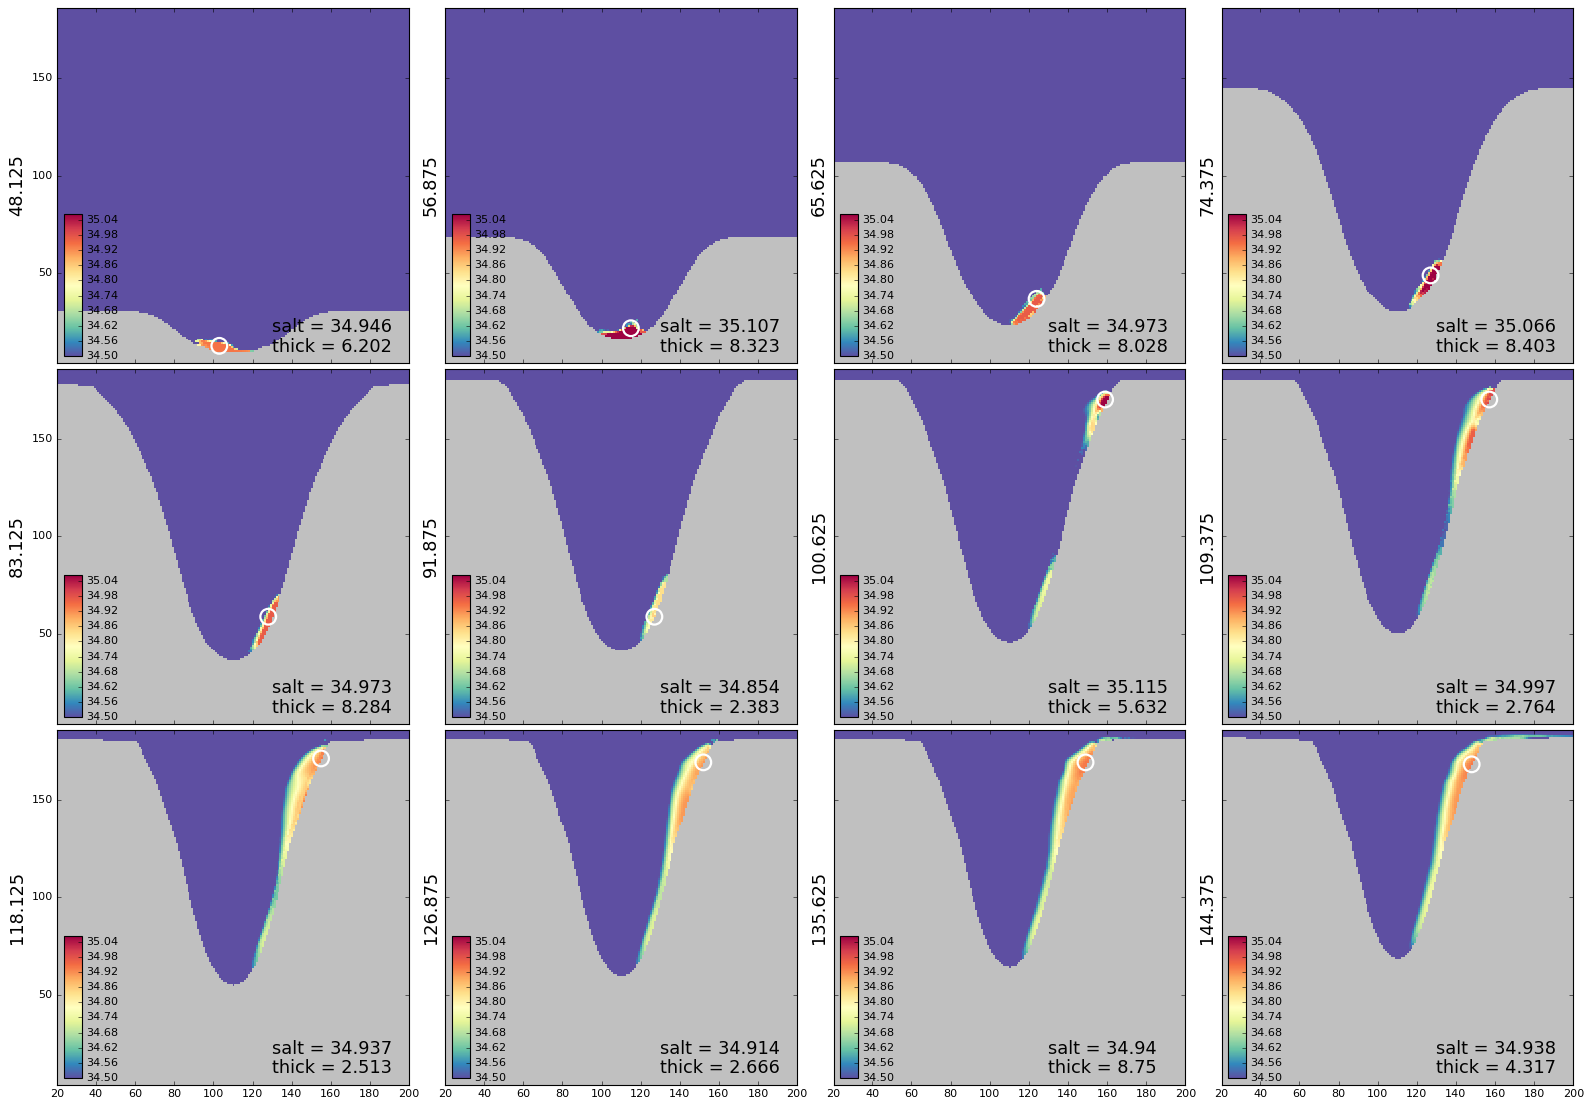

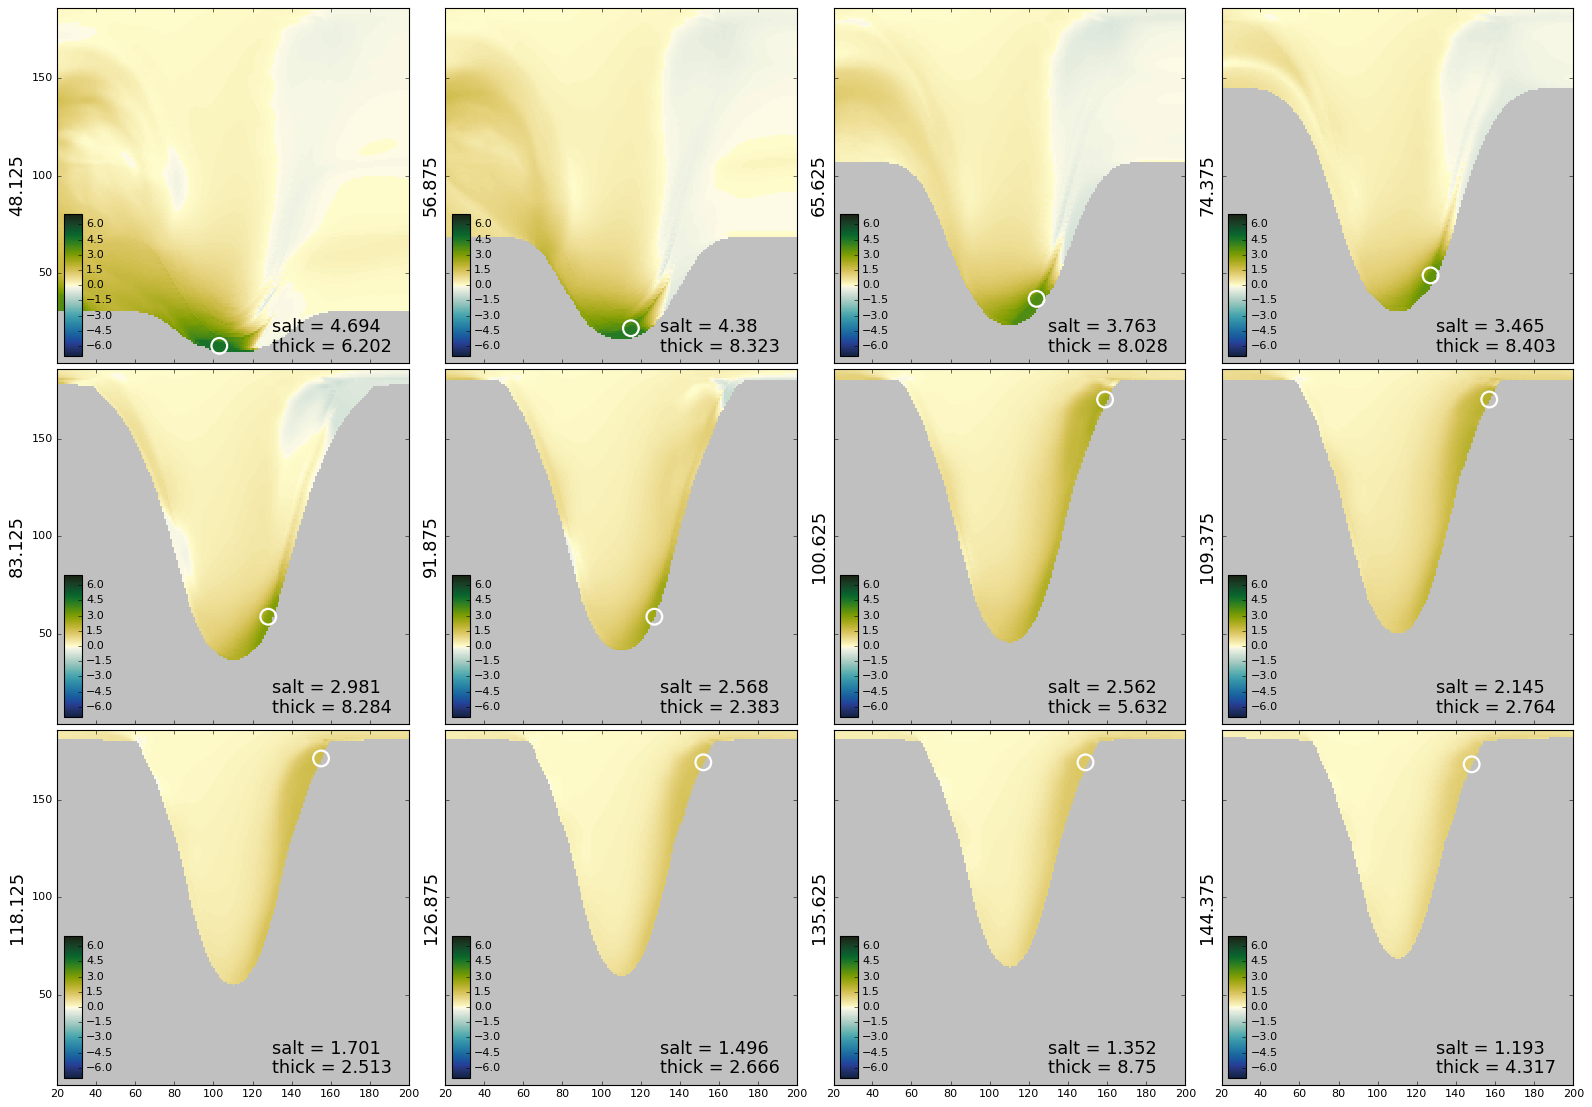

In [65]:
fname = '1_MCKNZ_1h_20170101_201701*'
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/'
case = 'ideal_base'
time_ind=85

fig = plot_salt(fname, dirname, case, time_ind, vosaline_ref, None)
fig = plot_salt(fname, dirname, case, time_ind, vosaline_ref, 'anomaly')

# Case 2
## Run: ideal_base_nambfr -- Salt: 35.0636 -- Thickness: 2.2003 -- Hour: 124

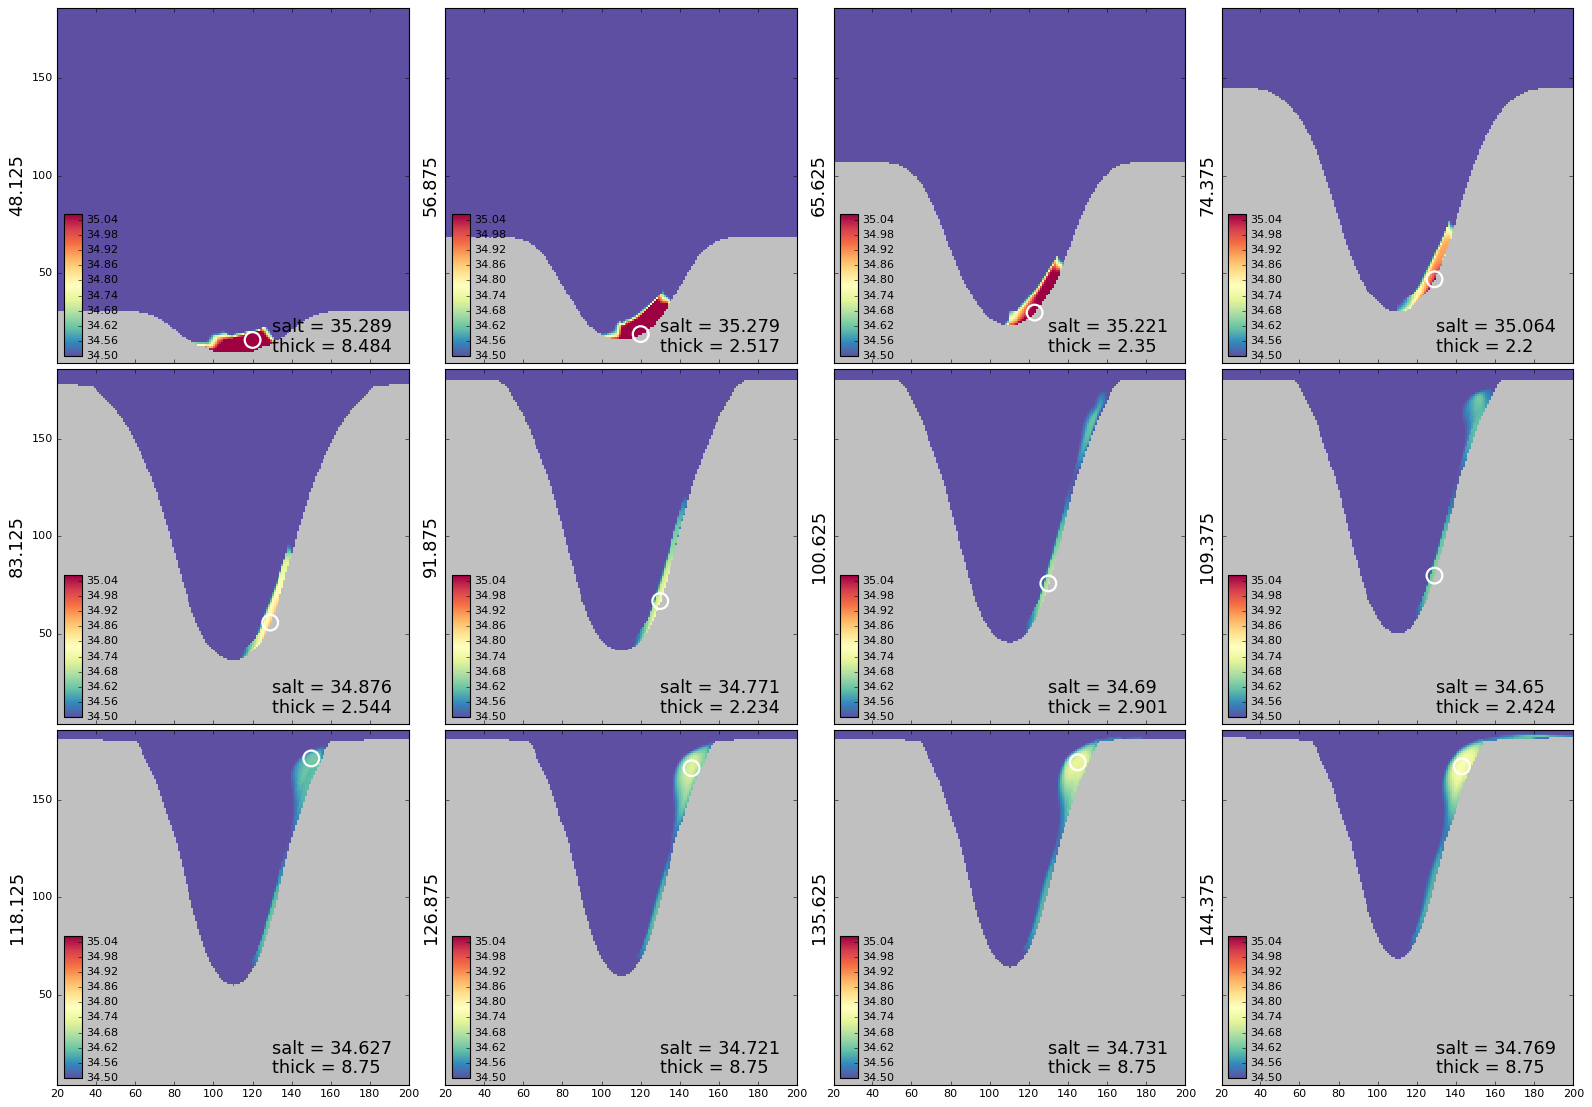

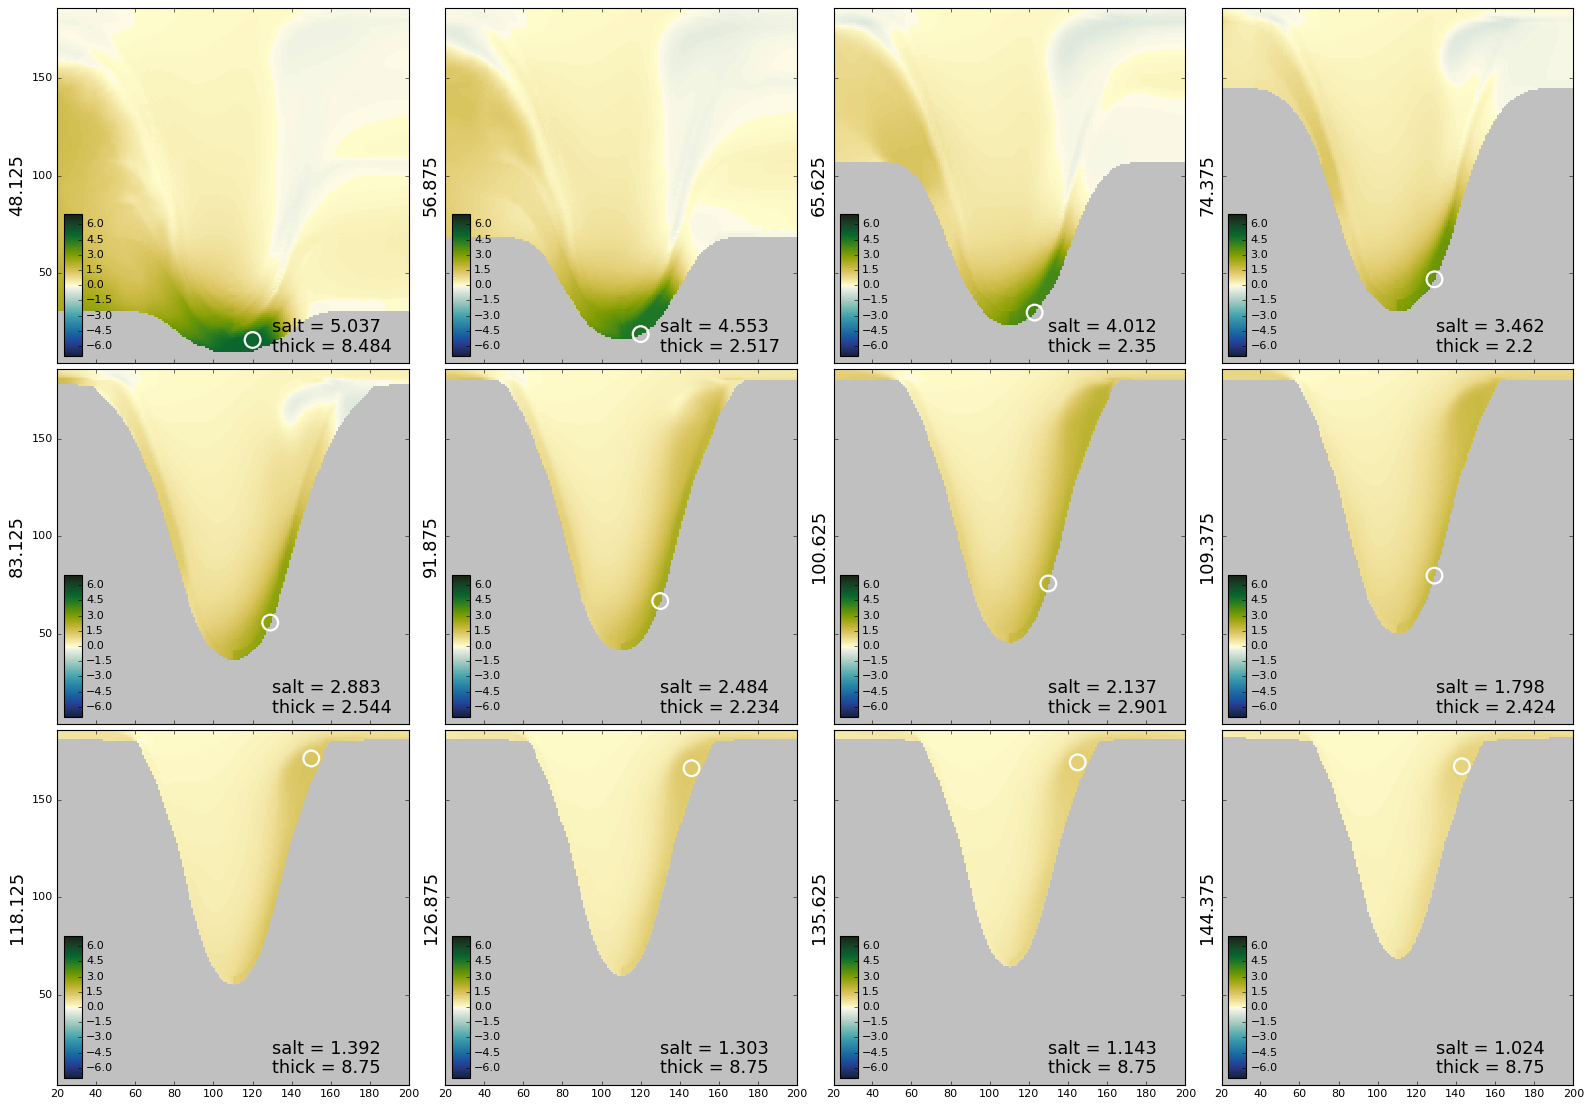

In [66]:
fname = '1_MCKNZ_1h_20170101_201701*'
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/'
case = 'ideal_base_nambfr'
time_ind=124

fig = plot_salt(fname, dirname, case, time_ind, vosaline_ref, None)
fig = plot_salt(fname, dirname, case, time_ind, vosaline_ref, 'anomaly')

In [144]:
fname = '1_MCKNZ_1h_20170101_201701*'
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/'
case = 'ideal_base'
time_ind=85

maskname = '1_mesh_mask.nc'
y,x = slice(1,-1,None), slice(1,-1,None)
with nc.Dataset(os.path.join(dirname+case, maskname), 'r') as dsM:
    tmask = dsM.variables['tmask'][0, :, y, x]

In [150]:
z_max = 12
salt_wall = np.zeros((z_max, tmask.shape[-1]))
for k in range(z_max):
    for i in range(tmask.shape[-1]):
        j = np.where(tmask[k, :, i] == 1)[0][0]
        salt_wall[k, i] = get_salt(fname, dirname+case, time_ind, k, j, i)

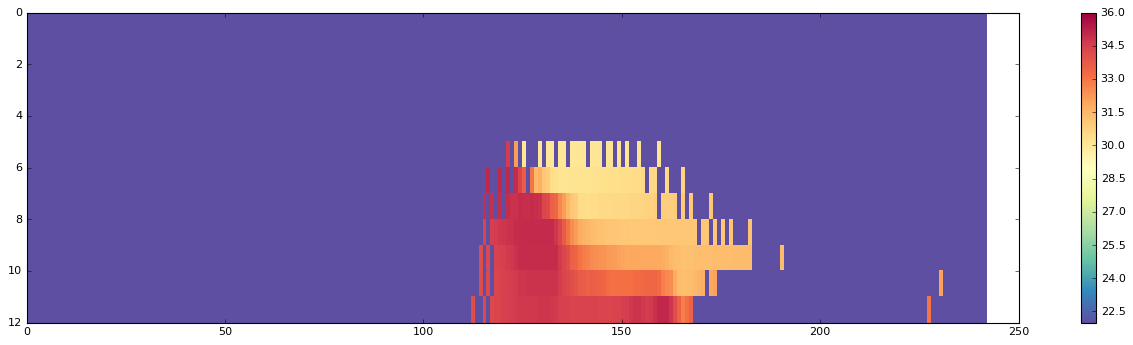

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
p = ax.pcolormesh(salt_wall, cmap = cm.Spectral_r, vmin=22, vmax=36)
fig.colorbar(p)
ax.invert_yaxis()